In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from imblearn.under_sampling import RandomUnderSampler
import random
random.seed(42)

In [2]:
websites=["akakce","amazon","arabam","donanimhaber","haberturk","mgm","nefisyemektarifleri","pazarama","trendyol"]

datas=[]
for website in websites:
    data=pd.read_csv(website+"_paired.csv",encoding='latin1')
    data = data.groupby("pair").apply(lambda x: x.sample(min(184,len(x)))).reset_index(drop=True)
    print(website,data.shape)
    datas.append(data)
data=pd.concat(datas,ignore_index=True)
#drop the rows with pair value count is 1
valuecounts=data["pair"].value_counts()
data["pairC"] = data["pair"].map(lambda x: valuecounts[x])
data = data[data["pairC"] > 1].reset_index(drop=True)
print(data.shape)
data.head()

akakce (2217, 6)
amazon (2927, 6)
arabam (4027, 6)
donanimhaber (773, 6)
haberturk (28327, 6)
mgm (3936, 6)
nefisyemektarifleri (2468, 6)
pazarama (1536, 6)
trendyol (1357, 6)
(45943, 7)


,url1,url2,url1_dir,url2_dir,pair,identical,pairC
0,https://www.akakce.com/brosurler/a101,https://www.akakce.com/yorum/?p=436908675#Yoru...,www.akakce.com/78,www.akakce.com/81,aktcom,False,3
1,https://www.akakce.com/brosurler/a101,https://www.akakce.com/yorum/?p=131983292#Yoru...,www.akakce.com/78,www.akakce.com/79,aktcom,False,3
2,https://www.akakce.com/brosurler/a101,https://www.akakce.com/yorum/?p=1958594929,www.akakce.com/78,www.akakce.com/80,aktcom,False,3
3,https://www.akakce.com/brosurler/a101,https://www.akakce.com/#/9876/?z=144&v=2108&s=...,www.akakce.com/78,www.akakce.com/89,akthome,False,2
4,https://www.akakce.com/brosurler/a101,https://www.akakce.com/,www.akakce.com/78,www.akakce.com/90,akthome,False,2


In [4]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.models import Model

input_shape = (256, 256, 3)
input_1 = Input(shape=input_shape, name='input_1')
input_2 = Input(shape=input_shape, name='input_2')

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
base_model.trainable = True


features_1 = base_model(input_1)
features_2 = base_model(input_2)


pool_1 = GlobalAveragePooling2D()(features_1)
pool_2 = GlobalAveragePooling2D()(features_2)
combined = Concatenate()([pool_1, pool_2])

x = Dense(2048, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[input_1, input_2], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3,decay=1e-4), loss='binary_crossentropy', metrics=["accuracy",tf.keras.metrics.AUC(),tf.keras.metrics.SensitivityAtSpecificity(0.99),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 8, 8, 2048)   23587712    ['input_1[0][0]',                
                                                                  'input_2[0][0]']          

In [32]:
def load_and_preprocess_image(path, img_size=(256, 256)):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)  
    image = tf.image.resize(image, img_size)
    image = tf.keras.applications.resnet50.preprocess_input(image)  # normalize for ResNet
    return image

def make_dataset(image_paths_1, image_paths_2, labels, batch_size=32, shuffle=True):
    path_ds_1 = tf.data.Dataset.from_tensor_slices(image_paths_1)
    path_ds_2 = tf.data.Dataset.from_tensor_slices(image_paths_2)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)

    def process_pair(path1, path2, label):
        img1 = load_and_preprocess_image("data/"+path1+"/ss.png")
        img2 = load_and_preprocess_image("data/"+path2+"/ss.png")
        return {'input_1': img1, 'input_2': img2}, label

    dataset = tf.data.Dataset.zip((path_ds_1, path_ds_2, label_ds))
    dataset = dataset.map(process_pair, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(labels))

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

from sklearn.model_selection import train_test_split
train, test = train_test_split(
    data,stratify=data["pair"],
    test_size=0.2,
    random_state=42,
    shuffle=True,
)
train, val = train_test_split(
    train, stratify=train["pair"],
    test_size=0.2,
    random_state=42,
    shuffle=True,
)
train_dataset = make_dataset(train["url1_dir"].to_numpy(), train["url2_dir"].to_numpy(), train["identical"].to_numpy(), batch_size=32, shuffle=False)
val_dataset = make_dataset(val["url1_dir"].to_numpy(), val["url2_dir"].to_numpy(), val["identical"].to_numpy(), batch_size=32, shuffle=False)
test_dataset = make_dataset(test["url1_dir"].to_numpy(), test["url2_dir"].to_numpy(), test["identical"].to_numpy(), batch_size=32, shuffle=False)
# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("resnet50.h5", save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/50
912/912 [==============================] - 613s 665ms/step - loss: 0.2385 - accuracy: 0.9190 - auc_2: 0.8417 - sensitivity_at_specificity_2: 0.0000e+00 - val_loss: 0.2195 - val_accuracy: 0.9170 - val_auc_2: 0.8781 - val_sensitivity_at_specificity_2: 0.0000e+00
Epoch 2/50
912/912 [==============================] - 604s 663ms/step - loss: 0.1289 - accuracy: 0.9476 - auc_2: 0.9586 - sensitivity_at_specificity_2: 0.0046 - val_loss: 0.1278 - val_accuracy: 0.9641 - val_auc_2: 0.9532 - val_sensitivity_at_specificity_2: 0.1932
Epoch 3/50
912/912 [==============================] - 623s 683ms/step - loss: 0.0710 - accuracy: 0.9753 - auc_2: 0.9857 - sensitivity_at_specificity_2: 0.0698 - val_loss: 0.0525 - val_accuracy: 0.9837 - val_auc_2: 0.9892 - val_sensitivity_at_specificity_2: 0.5617
Epoch 4/50
912/912 [==============================] - 593s 650ms/step - loss: 0.0491 - accuracy: 0.9822 - auc_2: 0.9918 - sensitivity_at_specificity_2: 0.0000e+00 - val_loss: 0.0942 - val_accuracy: 0.

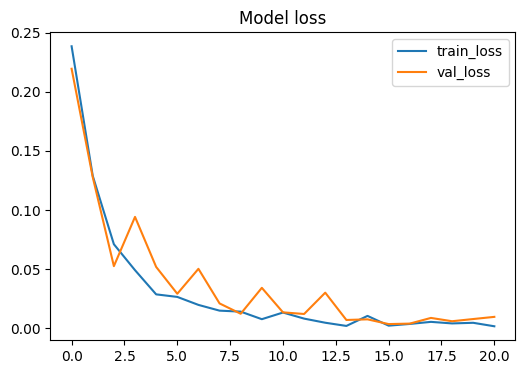

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.show()

In [34]:
model.evaluate(test_dataset, verbose=1)
model.save("models/resnet50_noreduce.h5")

285/285 [==============================] - 42s 147ms/step - loss: 0.0055 - accuracy: 0.9988 - auc_2: 0.9980 - sensitivity_at_specificity_2: 0.9843


In [7]:
def load_and_preprocess_image(path, img_size=(256, 256)):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)  
    image = tf.image.resize(image, img_size)
    image = tf.keras.applications.resnet50.preprocess_input(image)  # normalize for ResNet
    return image

def make_dataset(image_paths_1, image_paths_2, labels, batch_size=32, shuffle=True):
    path_ds_1 = tf.data.Dataset.from_tensor_slices(image_paths_1)
    path_ds_2 = tf.data.Dataset.from_tensor_slices(image_paths_2)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)

    def process_pair(path1, path2, label):
        img1 = load_and_preprocess_image("data/"+path1+"/ss.png")
        img2 = load_and_preprocess_image("data/"+path2+"/ss.png")
        return {'input_1': img1, 'input_2': img2}, label

    dataset = tf.data.Dataset.zip((path_ds_1, path_ds_2, label_ds))
    dataset = dataset.map(process_pair, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(labels))

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

from sklearn.model_selection import train_test_split
train, test = train_test_split(
    data,stratify=data["pair"],
    test_size=0.2,
    random_state=42,
    shuffle=True,
)
train, val = train_test_split(
    train, stratify=train["pair"],
    test_size=0.2,
    random_state=42,
    shuffle=True,
)
train_dataset = make_dataset(train["url1_dir"].to_numpy(), train["url2_dir"].to_numpy(), train["identical"].to_numpy(), batch_size=32, shuffle=False)
val_dataset = make_dataset(val["url1_dir"].to_numpy(), val["url2_dir"].to_numpy(), val["identical"].to_numpy(), batch_size=32, shuffle=False)
test_dataset = make_dataset(test["url1_dir"].to_numpy(), test["url2_dir"].to_numpy(), test["identical"].to_numpy(), batch_size=32, shuffle=False)

model.load_weights("models/resnet50_noreduce.h5")
model.evaluate(test_dataset, verbose=1)

288/288 [==============================] - 51s 148ms/step - loss: 0.0058 - accuracy: 0.9987 - auc_1: 0.9982 - sensitivity_at_specificity_1: 0.9964 - precision: 0.9976 - recall: 0.9880


[0.005754474550485611,
 0.9986940622329712,
 0.9981827139854431,
 0.9964115023612976,
 0.9975845217704773,
 0.9880383014678955]